In [1]:
#Importing the necessary libraries
import platform
print("Python version:", platform.python_version())

import sys
import os

import tensorflow as tf
print("tensorflow version:",tf.__version__)

import numpy as np
print("numpy version:",np.__version__)

import cv2
print("cv2 version:",cv2.__version__)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
print("matplotlib version:",matplotlib.__version__)

import pandas as pd
print("pandas version:",pd.__version__)

from skimage.transform import resize

from tensorflow.keras import datasets, layers, models

Python version: 3.10.12
tensorflow version: 2.10.0
numpy version: 1.26.1
cv2 version: 4.8.1
matplotlib version: 3.8.0
pandas version: 2.1.2


In [2]:
# Check for GPU availability
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
"""
Utility functions for Unet3+ models
"""
import tensorflow as tf
import tensorflow.keras as k


def conv_block(x, kernels, kernel_size=(3, 3), strides=(1, 1), padding='same',
               is_bn=True, is_relu=True, n=2):
    """ Custom function for conv2d:
        Apply  3*3 convolutions with BN and relu.
    """
    for i in range(1, n + 1):
        x = k.layers.Conv2D(filters=kernels, kernel_size=kernel_size,
                            padding=padding, strides=strides,
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                            kernel_initializer=k.initializers.he_normal(seed=5))(x)
        if is_bn:
            x = k.layers.BatchNormalization()(x)
        if is_relu:
            x = k.activations.relu(x)

    return x


def dot_product(seg, cls):
    b, h, w, n = k.backend.int_shape(seg)
    seg = tf.reshape(seg, [-1, h * w, n])
    final = tf.einsum("ijk,ik->ijk", seg, cls)
    final = tf.reshape(final, [-1, h, w, n])
    return final

In [4]:
"""
UNet3+ base model
"""
import tensorflow as tf
import tensorflow.keras as k

def unet3plus(input_shape, output_channels):
    """ UNet3+ base model """
    filters = [64, 128, 256, 512, 1024]

    input_layer = k.layers.Input(
        shape=input_shape,
        name="input_layer"
    )  # 320*320*3

    """ Encoder"""
    # block 1
    e1 = conv_block(input_layer, filters[0])  # 320*320*64

    # block 2
    e2 = k.layers.MaxPool2D(pool_size=(2, 2))(e1)  # 160*160*64
    e2 = conv_block(e2, filters[1])  # 160*160*128

    # block 3
    e3 = k.layers.MaxPool2D(pool_size=(2, 2))(e2)  # 80*80*128
    e3 = conv_block(e3, filters[2])  # 80*80*256

    # block 4
    e4 = k.layers.MaxPool2D(pool_size=(2, 2))(e3)  # 40*40*256
    e4 = conv_block(e4, filters[3])  # 40*40*512

    # block 5
    # bottleneck layer
    e5 = k.layers.MaxPool2D(pool_size=(2, 2))(e4)  # 20*20*512
    e5 = conv_block(e5, filters[4])  # 20*20*1024

    """ Decoder """
    cat_channels = filters[0]
    cat_blocks = len(filters)
    upsample_channels = cat_blocks * cat_channels

    """ d4 """
    e1_d4 = k.layers.MaxPool2D(pool_size=(8, 8))(e1)  # 320*320*64  --> 40*40*64
    e1_d4 = conv_block(e1_d4, cat_channels, n=1)  # 320*320*64  --> 40*40*64

    e2_d4 = k.layers.MaxPool2D(pool_size=(4, 4))(e2)  # 160*160*128 --> 40*40*128
    e2_d4 = conv_block(e2_d4, cat_channels, n=1)  # 160*160*128 --> 40*40*64

    e3_d4 = k.layers.MaxPool2D(pool_size=(2, 2))(e3)  # 80*80*256  --> 40*40*256
    e3_d4 = conv_block(e3_d4, cat_channels, n=1)  # 80*80*256  --> 40*40*64

    e4_d4 = conv_block(e4, cat_channels, n=1)  # 40*40*512  --> 40*40*64

    e5_d4 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(e5)  # 80*80*256  --> 40*40*256
    e5_d4 = conv_block(e5_d4, cat_channels, n=1)  # 20*20*1024  --> 20*20*64

    d4 = k.layers.concatenate([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = conv_block(d4, upsample_channels, n=1)  # 40*40*320  --> 40*40*320

    """ d3 """
    e1_d3 = k.layers.MaxPool2D(pool_size=(4, 4))(e1)  # 320*320*64 --> 80*80*64
    e1_d3 = conv_block(e1_d3, cat_channels, n=1)  # 80*80*64 --> 80*80*64

    e2_d3 = k.layers.MaxPool2D(pool_size=(2, 2))(e2)  # 160*160*256 --> 80*80*256
    e2_d3 = conv_block(e2_d3, cat_channels, n=1)  # 80*80*256 --> 80*80*64

    e3_d3 = conv_block(e3, cat_channels, n=1)  # 80*80*512 --> 80*80*64

    e4_d3 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d4)  # 40*40*320 --> 80*80*320
    e4_d3 = conv_block(e4_d3, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    e5_d3 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(e5)  # 20*20*320 --> 80*80*320
    e5_d3 = conv_block(e5_d3, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    d3 = k.layers.concatenate([e1_d3, e2_d3, e3_d3, e4_d3, e5_d3])
    d3 = conv_block(d3, upsample_channels, n=1)  # 80*80*320 --> 80*80*320

    """ d2 """
    e1_d2 = k.layers.MaxPool2D(pool_size=(2, 2))(e1)  # 320*320*64 --> 160*160*64
    e1_d2 = conv_block(e1_d2, cat_channels, n=1)  # 160*160*64 --> 160*160*64

    e2_d2 = conv_block(e2, cat_channels, n=1)  # 160*160*256 --> 160*160*64

    d3_d2 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d3)  # 80*80*320 --> 160*160*320
    d3_d2 = conv_block(d3_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d4_d2 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(d4)  # 40*40*320 --> 160*160*320
    d4_d2 = conv_block(d4_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    e5_d2 = k.layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(e5)  # 20*20*320 --> 160*160*320
    e5_d2 = conv_block(e5_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d2 = k.layers.concatenate([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = conv_block(d2, upsample_channels, n=1)  # 160*160*320 --> 160*160*320

    """ d1 """
    e1_d1 = conv_block(e1, cat_channels, n=1)  # 320*320*64 --> 320*320*64

    d2_d1 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d2)  # 160*160*320 --> 320*320*320
    d2_d1 = conv_block(d2_d1, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d3_d1 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(d3)  # 80*80*320 --> 320*320*320
    d3_d1 = conv_block(d3_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d4_d1 = k.layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(d4)  # 40*40*320 --> 320*320*320
    d4_d1 = conv_block(d4_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    e5_d1 = k.layers.UpSampling2D(size=(16, 16), interpolation='bilinear')(e5)  # 20*20*320 --> 320*320*320
    e5_d1 = conv_block(e5_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d1 = k.layers.concatenate([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1, ])
    d1 = conv_block(d1, upsample_channels, n=1)  # 320*320*320 --> 320*320*320

    # last layer does not have batchnorm and relu
    d = conv_block(d1, output_channels, n=1, is_bn=False, is_relu=False)

    output = k.activations.softmax(d)

    return tf.keras.Model(inputs=input_layer, outputs=[output], name='UNet_3Plus')

In [5]:
INPUT_SHAPE = [320, 320, 3]
OUTPUT_CHANNELS = 1

unet_3P = unet3plus(INPUT_SHAPE, OUTPUT_CHANNELS)
unet_3P.summary()

# tf.keras.utils.plot_model(unet_3P, show_layer_names=True, show_shapes=True)

# unet_3P.save("unet_3P.hdf5")

Model: "UNet_3Plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 320, 320, 64  1792        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 320, 320, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                        

In [6]:
#Function to change the path format
def path_correct(path):
  path = '/'.join(path[2:].split('\\'))
  path = os.path.join(path_ds, path)
  return path

In [7]:
#Loading the training data for damage images
#Access the csv file containing the absolute directory paths to each file
path_ds = os.path.join('IC-SHM_2021','Tokaido_dataset') #put a path to the dataset
col_names = ['image file name', 'component label file name', 'damage label file name', 'depth image file name',
             'camera focal length in mm', 'regular images', 'images containing damage in the RRDR']
ftrain = pd.read_csv(os.path.join(path_ds,'files_train.csv'),names = col_names,delimiter=',')
ftrain.iloc[:,0] = ftrain.iloc[:,0].apply(lambda x: path_correct(x))
ftrain.iloc[:,1] = ftrain.iloc[:,1].apply(lambda x: path_correct(x))
ftrain.iloc[:,2] = ftrain.iloc[:,2].apply(lambda x: path_correct(x))
ftrain.iloc[:,3] = ftrain.iloc[:,3].apply(lambda x: path_correct(x))
train_comp = ftrain.loc[ftrain['regular images']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]
train_dmg = ftrain.loc[ftrain['images containing damage in the RRDR']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]


In [8]:
print(len(train_dmg))

4381


In [9]:
train_dmg

image file name  \
0      IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   
3      IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   
5      IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   
7      IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   
11     IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   
...                                                  ...   
13941  IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   
13942  IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   
13945  IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   
13949  IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   
13955  IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   

                               component label file name  \
0      IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
3      IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
5      IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
7      IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
11     IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
...                                                  ...   
13941  IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
13942  IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
13945  IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
13949  IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
13955  IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   

                                  damage label file name  \
0      IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
3      IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
5      IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
7      IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
11     IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
...                                                  ...   
13941  IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
13942  IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
13945  IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
13949  IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
13955  IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   

                                   depth image file name  \
0      IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   
3      IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   
5      IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   
7      IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   
11     IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   
...                                                  ...   
13941  IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   
13942  IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   
13945  IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   
13949  IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   
13955  IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   

       camera focal length in mm  
0                      43.375470  
3                      43.242723  
5                      20.921244  
7                      46.639972  
11                     53.623157  
...                          ...  
13941                  51.725212  
13942                  53.422408  
13945                  41.561651  
13949                  36.669088  
13955                  54.680956  

[4381 rows x 5 columns]

image file name                         IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...
component label file name               IC-SHM_2021\Tokaido_dataset\synthetic/train/la...
damage label file name                  IC-SHM_2021\Tokaido_dataset\synthetic/train/la...
depth image file name                   IC-SHM_2021\Tokaido_dataset\synthetic/train/de...
camera focal length in mm                                                       43.242723
regular images                                                                       True
images containing damage in the RRDR                                                 True
Name: 3, dtype: object
(1080, 1920, 3)
<class 'numpy.ndarray'>


C:\Users\NBP_RP268\AppData\Local\Temp\ipykernel_13888\4107609199.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = mpimg.imread(ftrain.iloc[3][0])


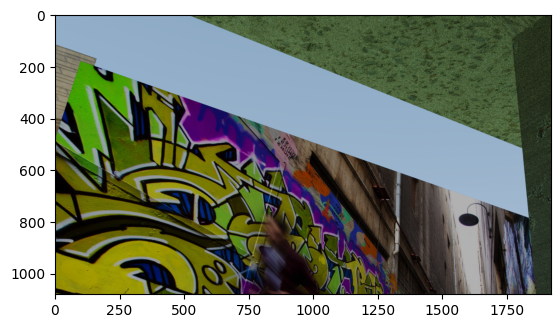

In [10]:
#Printing the training image

#image
print(ftrain.iloc[3])
image = mpimg.imread(ftrain.iloc[3][0])
print(image.shape)
print(type(image))
plt.imshow(image)

image file name                         IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...
component label file name               IC-SHM_2021\Tokaido_dataset\synthetic/train/la...
damage label file name                  IC-SHM_2021\Tokaido_dataset\synthetic/train/la...
depth image file name                   IC-SHM_2021\Tokaido_dataset\synthetic/train/de...
camera focal length in mm                                                       43.242723
regular images                                                                       True
images containing damage in the RRDR                                                 True
Name: 3, dtype: object
(360, 640)
<class 'numpy.ndarray'>


C:\Users\NBP_RP268\AppData\Local\Temp\ipykernel_13888\3998249144.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = mpimg.imread(ftrain.iloc[3][2])#[x][y] x = row no. & y = {0:raw image, 1:component label, 2:damage label, 3:depth label}


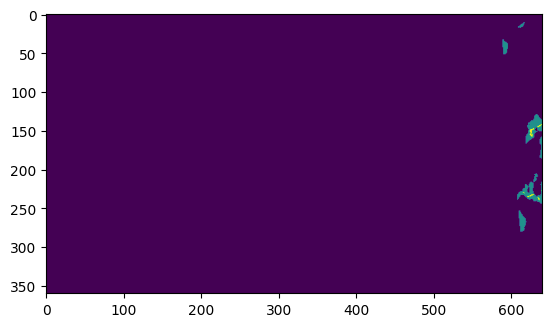

In [11]:
#label
#Printing the above image label
print(ftrain.iloc[3])
image = mpimg.imread(ftrain.iloc[3][2])#[x][y] x = row no. & y = {0:raw image, 1:component label, 2:damage label, 3:depth label}
print(image.shape)
print(type(image))
plt.imshow(image)

In [12]:
#Run for training on the damage images
train1 = train_dmg[:4000]
val1 = train_dmg[4000:]

image file name           IC-SHM_2021\Tokaido_dataset\images_puretex/im8...
damage label file name    IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...
Name: 0, dtype: object
(360, 640)
<class 'numpy.ndarray'>


C:\Users\NBP_RP268\AppData\Local\Temp\ipykernel_13888\347379401.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = mpimg.imread(ftrain.iloc[0][1])


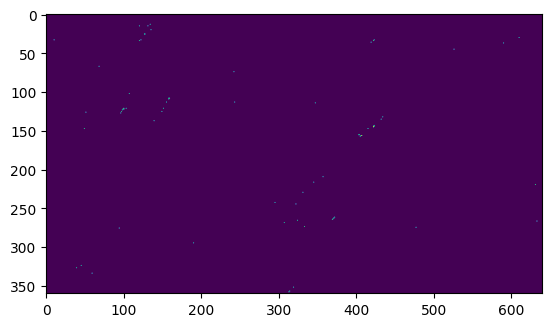

In [13]:
#Loading the training data from the pure_tex file

#Access the csv file containing the absolute directory paths to each file
path_ds = os.path.join('IC-SHM_2021','Tokaido_dataset') #put a path to the dataset
col_names = ['image file name', 'damage label file name']

ftrain = pd.read_csv(os.path.join(path_ds,'files_puretex_train.csv'),names = col_names,delimiter=',')
ftrain.iloc[:,0] = ftrain.iloc[:,0].apply(lambda x: path_correct(x))
ftrain.iloc[:,1] = ftrain.iloc[:,1].apply(lambda x: path_correct(x))

train_tex = ftrain
#Printing the training image
print(ftrain.iloc[0])
image = mpimg.imread(ftrain.iloc[0][1])
print(image.shape)
print(type(image))
plt.imshow(image)

In [14]:
print(len(train_tex))

2700


In [15]:
train_tex

image file name  \
0     IC-SHM_2021\Tokaido_dataset\images_puretex/im8...   
1     IC-SHM_2021\Tokaido_dataset\images_puretex/im4...   
2     IC-SHM_2021\Tokaido_dataset\images_puretex/im7...   
3     IC-SHM_2021\Tokaido_dataset\images_puretex/im2...   
4     IC-SHM_2021\Tokaido_dataset\images_puretex/im9...   
...                                                 ...   
2695  IC-SHM_2021\Tokaido_dataset\images_puretex/im7...   
2696  IC-SHM_2021\Tokaido_dataset\images_puretex/im8...   
2697  IC-SHM_2021\Tokaido_dataset\images_puretex/im1...   
2698  IC-SHM_2021\Tokaido_dataset\images_puretex/im2...   
2699  IC-SHM_2021\Tokaido_dataset\images_puretex/im2...   

                                 damage label file name  
0     IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...  
1     IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...  
2     IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...  
3     IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...  
4     IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...  
...                                                 ...  
2695  IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...  
2696  IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...  
2697  IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...  
2698  IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...  
2699  IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...  

[2700 rows x 2 columns]

In [16]:
# Append the first 2300 rows from 'train_tex' to 'train1'
train1 = pd.concat([train1, train_tex[:2300]])

# Append the remaining rows from 'train_tex' to 'val1'
val1 = pd.concat([val1, train_tex[2300:]])

In [17]:
train1

image file name  \
0     IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   
3     IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   
5     IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   
7     IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   
11    IC-SHM_2021\Tokaido_dataset\img_syn_raw/train/...   
...                                                 ...   
2295  IC-SHM_2021\Tokaido_dataset\images_puretex/im2...   
2296  IC-SHM_2021\Tokaido_dataset\images_puretex/im7...   
2297  IC-SHM_2021\Tokaido_dataset\images_puretex/im2...   
2298  IC-SHM_2021\Tokaido_dataset\images_puretex/im8...   
2299  IC-SHM_2021\Tokaido_dataset\images_puretex/im2...   

                              component label file name  \
0     IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
3     IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
5     IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
7     IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
11    IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
...                                                 ...   
2295                                                NaN   
2296                                                NaN   
2297                                                NaN   
2298                                                NaN   
2299                                                NaN   

                                 damage label file name  \
0     IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
3     IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
5     IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
7     IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
11    IC-SHM_2021\Tokaido_dataset\synthetic/train/la...   
...                                                 ...   
2295  IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...   
2296  IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...   
2297  IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...   
2298  IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...   
2299  IC-SHM_2021\Tokaido_dataset\synthetic_puretex/...   

                                  depth image file name  \
0     IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   
3     IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   
5     IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   
7     IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   
11    IC-SHM_2021\Tokaido_dataset\synthetic/train/de...   
...                                                 ...   
2295                                                NaN   
2296                                                NaN   
2297                                                NaN   
2298                                                NaN   
2299                                                NaN   

      camera focal length in mm  
0                     43.375470  
3                     43.242723  
5                     20.921244  
7                     46.639972  
11                    53.623157  
...                         ...  
2295                        NaN  
2296                        NaN  
2297                        NaN  
2298                        NaN  
2299                        NaN  

[6300 rows x 5 columns]

In [18]:
def get_label(file_path):
    #img = tf.io.read_file(file_path)
    #mask = file_path
    mask = np.squeeze(file_path, axis = 2)
    target_array = np.zeros((mask.shape[0],mask.shape[1],3))
    target_array[:,:,0]=np.where(mask == 1, 1, 0)
    target_array[:,:,1]=np.where(mask == 2, 1, 0)
    target_array[:,:,2]=np.where(mask == 3, 1, 0)

    return target_array

In [19]:
def show_img(image):
  #image = np.squeeze(image, axis = -1)
  plt.figure()
  plt.imshow(image)
  plt.axis('off')

def show_label(label):
  fig, axes = plt.subplots(1, 3, figsize=(16, 112))
  y1 = label[:,:,0]
  y2 = label[:,:,1]
  y3 = label[:,:,2]
  plt.axis('off')
  axes[0].imshow(y1)
  axes[1].imshow(y2)
  axes[2].imshow(y3)

In [20]:
# Function to print the prediction images
def show_pred(y):
  fig, axes = plt.subplots(1, 3, figsize=(16, 112))
  y1 = y[:,:,0]
  y2 = y[:,:,1]
  y3 = y[:,:,2]
  plt.axis('off')
  axes[0].axis('off')
  axes[1].axis('off')
  axes[2].axis('off')
  axes[0].imshow(y1)
  axes[1].imshow(y2)
  axes[2].imshow(y3)


In [21]:
def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

In [22]:
def image_augmentation(img):
  seed = (2,3)
  img = tf.image.stateless_random_flip_left_right(img, seed)
  return img

def label_augmentation(img):
  seed = (2,3)
  img = tf.image.stateless_random_flip_left_right(img, seed)
  return img

In [23]:
def preprocess(x, y):
    def f(x, y):
        x = tf.io.read_file(x)
        y = tf.io.read_file(y)
        x = tf.io.decode_png(x, channels = 3)
        x = tf.image.resize_with_pad(x, 256, 448)
        x = tf.numpy_function(normalize, [x], [tf.float32])
        y = tf.io.decode_bmp(y, channels = 0)
        y = tf.numpy_function(get_label, [y], [tf.float32])
        y = tf.image.resize_with_pad(y, 256, 448)
        x = tf.numpy_function(image_augmentation, [x], [tf.float32])
        y = tf.numpy_function(label_augmentation, [y], [tf.float32])

        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([256, 448, 3])
    masks.set_shape([256, 448, 3])

    return images, masks

In [24]:
# Extract image and mask file paths from the CSV file
image_paths = train1['image file name'].values
mask_paths = train1['damage label file name'].values

In [25]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)


In [26]:
# Create training and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))

# Apply the preprocess function to load and preprocess images and masks
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)

# batch, and prefetch the datasets
train_batch_size = 2
val_batch_size = 2

train_dataset = train_dataset.batch(train_batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(val_batch_size).prefetch(tf.data.AUTOTUNE)

In [27]:
# images = train1['image file name'].to_numpy()
# masks = train1['damage label file name'].to_numpy()
# dataset = tf_dataset(images, masks)
# images_val = val1['image file name'].to_numpy()
# masks_val = val1['damage label file name'].to_numpy()
# dataset_val = tf_dataset(images_val, masks_val)

In [28]:
len(train_dataset)

2520

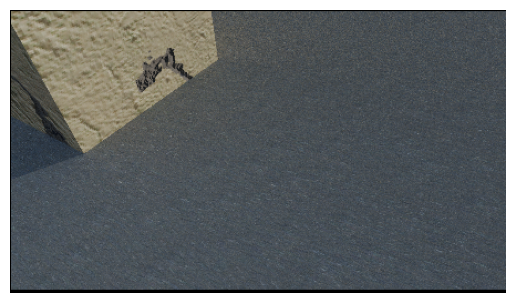

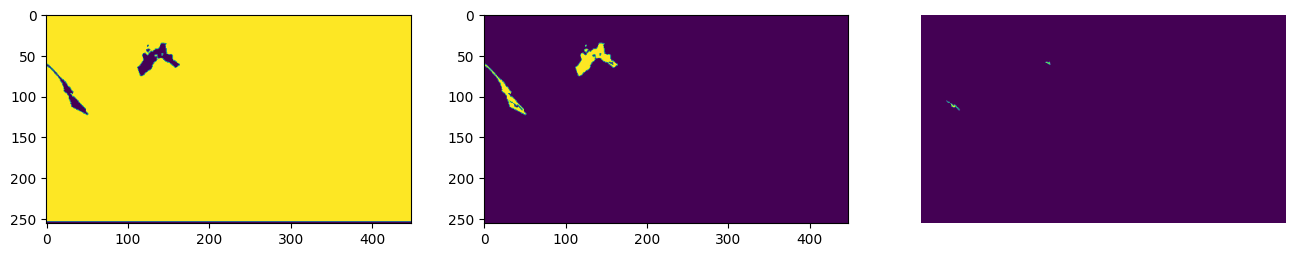

In [29]:
for batch in train_dataset:
        x, y = batch
        show_img(x[0])
        show_label(y[0])

        break

In [30]:
INPUT_SHAPE = [256, 448, 3]
OUTPUT_CHANNELS = 3

model = unet3plus(INPUT_SHAPE, OUTPUT_CHANNELS)
model.summary()

Model: "UNet_3Plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 256, 448, 64  1792        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 256, 448, 64  256        ['conv2d_35[0][0]']              
 ormalization)                  )                                                        

In [31]:
# The weights for each class are hardcoded here and are calculated using the code presented towards the end of this notebook
w1= 0.03611688490088685
w2= 1.0
w3=9.345573778790564

In [32]:
# Weights for the model trainig
class_weights = {0: w1, 1: w2, 2: w3}

In [33]:
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [46]:
checkpoint_path = os.path.join(path_ds, "saved-model-{epoch:02d}-{val_binary_accuracy:.2f}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,  monitor = 'iou', mode='max', save_best_only = False,
                                                 verbose=1)

In [47]:
from keras import backend as K
# Weighted loss function
def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last
        #axis =  1 #if channels first


        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index
        classSelectors = K.argmax(true, axis=axis)
        classSelectors = tf.cast(classSelectors, tf.int32)
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index
        classSelectors = [K.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations
        #each tensor in the list contains 1 where ground true class is equal to its index
        #if you sum all these, you will get a tensor full of ones.
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)]

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred)
        loss = loss * weightMultiplier

        return loss
    return lossFunc


In [48]:
#best results were obtained with binary cross entropy loss

model.compile(optimizer= optimizer_adam,
              loss=  weightedLoss(tf.keras.losses.BinaryCrossentropy(), [w1,w2,w3]),
              metrics=[
                       tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(thresholds = 0.2),
                       tf.keras.metrics.Precision(thresholds = 0.7),
                       tf.keras.metrics.MeanIoU(3,name="iou")])

In [49]:
history = model.fit(train_dataset, epochs= 10,validation_data=val_dataset, verbose = 1, callbacks=[cp_callback])

Epoch 1/10


2520/2520 [==============================] - ETA: 0s - loss: 0.5423 - binary_accuracy: 0.9701 - recall_3: 0.9770 - precision_3: 0.9791 - iou: 0.2510
Epoch 1: saving model to IC-SHM_2021\Tokaido_dataset\saved-model-01-0.97.ckpt
2520/2520 [==============================] - 2204s 872ms/step - loss: 0.5423 - binary_accuracy: 0.9701 - recall_3: 0.9770 - precision_3: 0.9791 - iou: 0.2510 - val_loss: 0.4690 - val_binary_accuracy: 0.9702 - val_recall_3: 0.9758 - val_precision_3: 0.9774 - val_iou: 0.2500
Epoch 2/10
2520/2520 [==============================] - ETA: 0s - loss: 0.4123 - binary_accuracy: 0.9716 - recall_3: 0.9783 - precision_3: 0.9804 - iou: 0.2518
Epoch 2: saving model to IC-SHM_2021\Tokaido_dataset\saved-model-02-0.97.ckpt
2520/2520 [==============================] - 2148s 853ms/step - loss: 0.4123 - binary_accuracy: 0.9716 - recall_3: 0.9783 - precision_3: 0.9804 - iou: 0.2518 - val_loss: 0.3694 - val_binary_accuracy: 0.9685 - val_recall_3: 0.9759 - val_precision_3: 0.9769 - val

KeyboardInterrupt: 

In [50]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
accu = history.history['binary_accuracy']
val_accu = history.history['val_binary_accuracy']

plt.figure()
plt.plot(history.epoch, accu, 'r', label='Training binary accuracy')
plt.plot(history.epoch, val_accu, 'b', label='Validation binary accuracy')
plt.title('Training and Validation binary accuracy')
plt.xlabel('Epoch')
plt.ylabel('binary accuracy Value')
plt.legend()
plt.show()

In [ ]:
recall = history.history['recall']
val_recall = history.history['val_recall']

plt.figure()
plt.plot(history.epoch, recall, 'r', label='Training recall')
plt.plot(history.epoch, val_recall, 'b', label='Validation recall')
plt.title('Training and Validation recall')
plt.xlabel('Epoch')
plt.ylabel('recall Value')
plt.legend()
plt.show()

In [ ]:
pres = history.history['precision']
val_pres = history.history['val_precision']

plt.figure()
plt.plot(history.epoch, pres, 'r', label='Training precision')
plt.plot(history.epoch, val_pres, 'b', label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision Value')
plt.legend()
plt.show()

In [ ]:
miou = history.history['mean_io_u']
val_miou = history.history['val_mean_io_u']

plt.figure()
plt.plot(history.epoch, miou, 'r', label='Training mean_io_u')
plt.plot(history.epoch, val_miou, 'b', label='Validation mean_io_u')
plt.title('Training and Validation mean_io_u')
plt.xlabel('Epoch')
plt.ylabel('mean_io_u Value')
plt.legend()
plt.show()

In [51]:
def show_pred(y):
  fig, axes = plt.subplots(1, 3, figsize=(16, 112))
  y1 = y[:,:,0]
  y2 = y[:,:,1]
  y3 = y[:,:,2]
  plt.axis('off')
  axes[0].imshow(y1)
  axes[1].imshow(y2)
  axes[2].imshow(y3)

1/1 [==============================] - 0s 48ms/step


C:\Users\NBP_RP268\AppData\Local\Temp\ipykernel_13888\4280269924.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(16, 112))


1/1 [==============================] - 0s 40ms/step


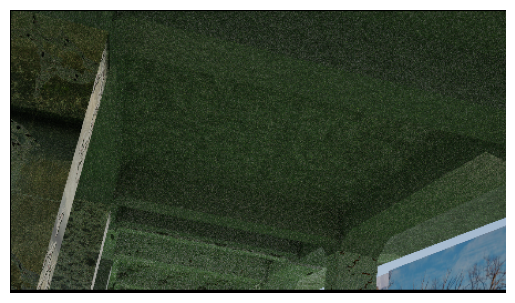

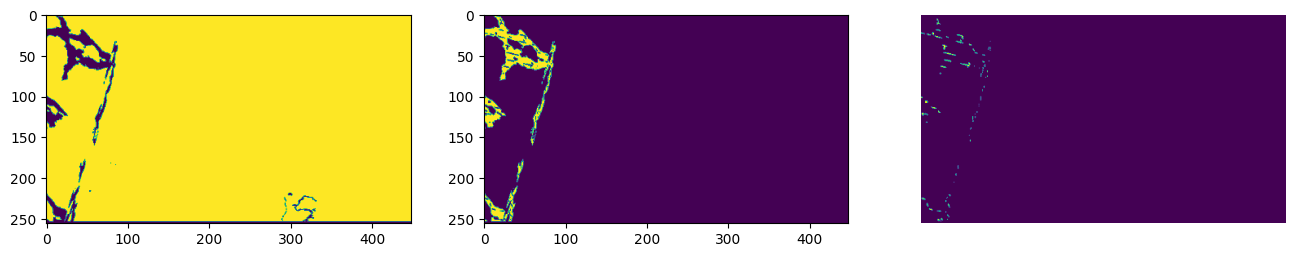

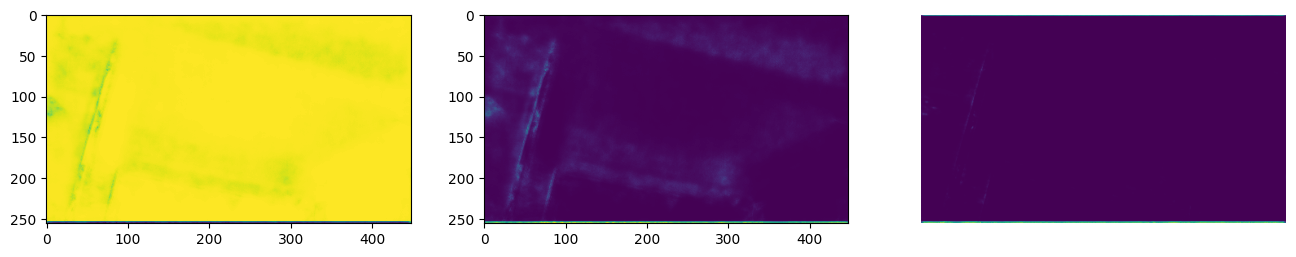

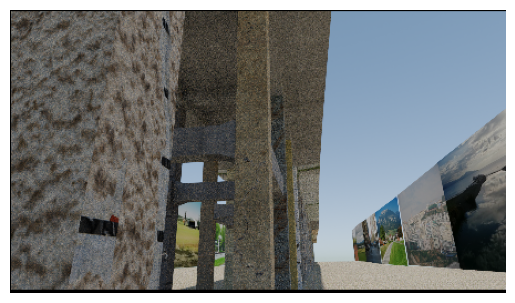

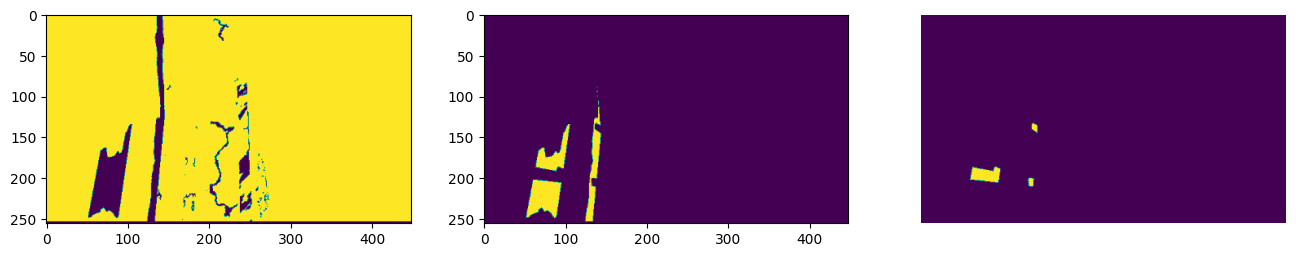

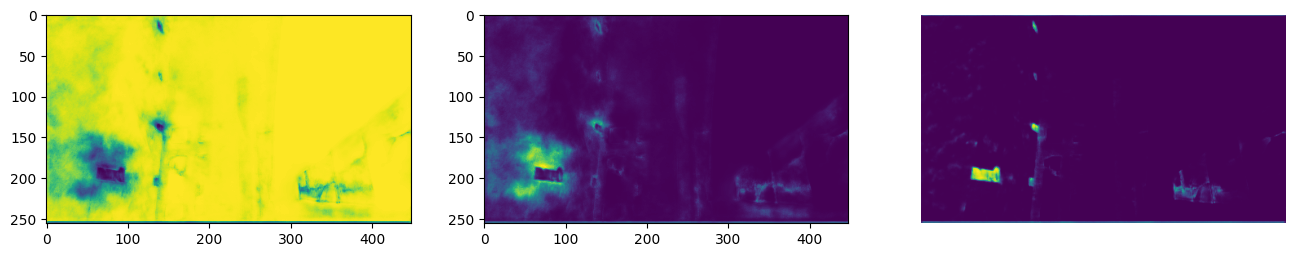

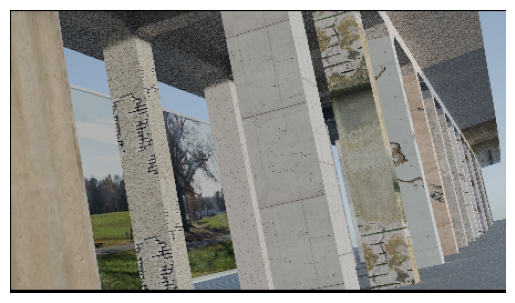

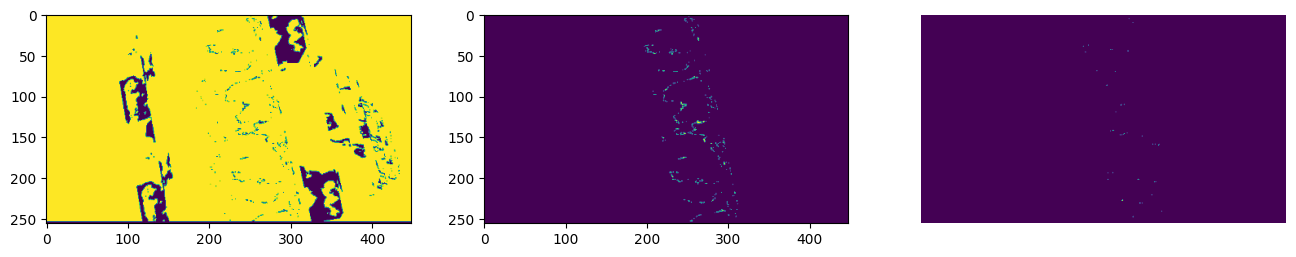

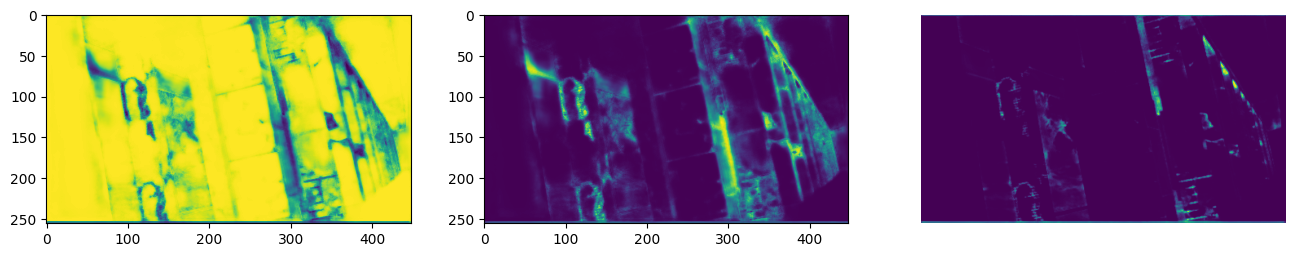

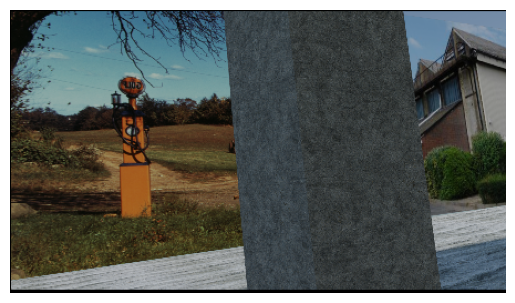

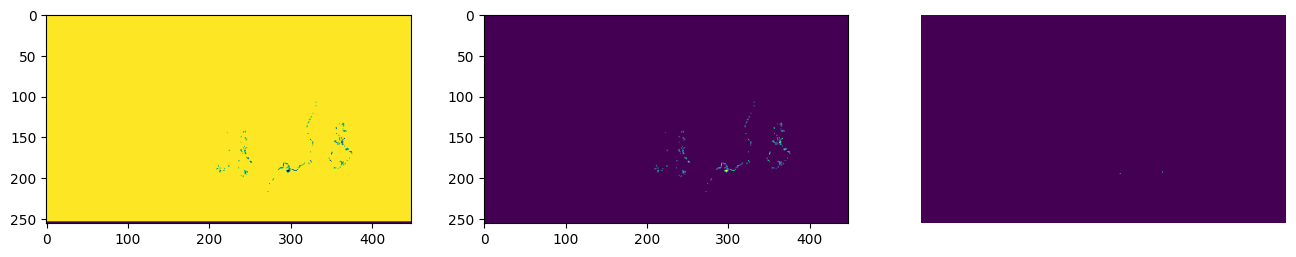

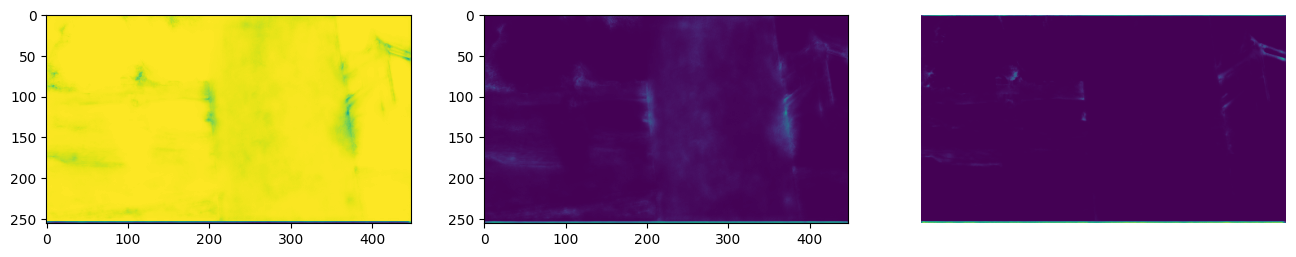

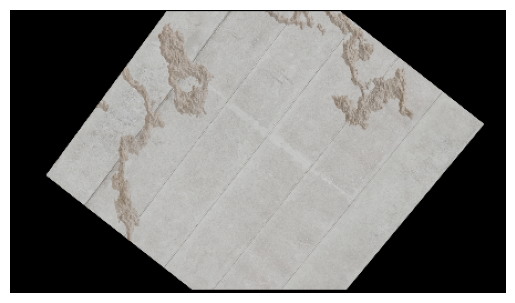

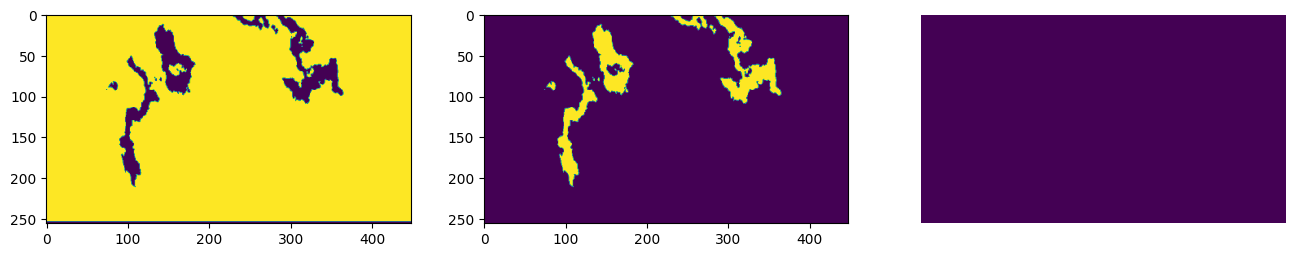

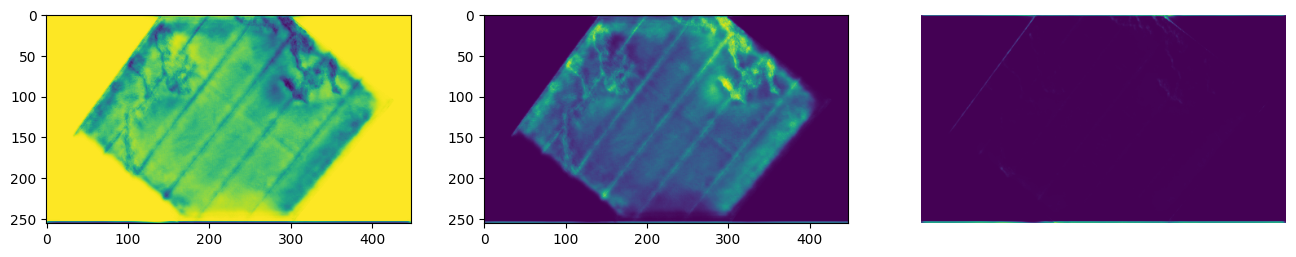

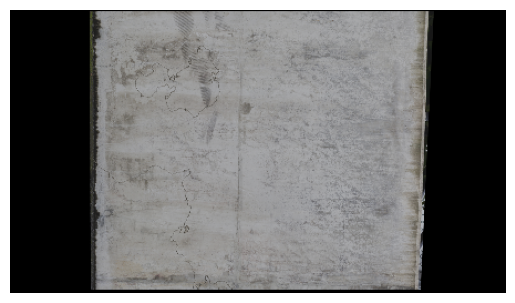

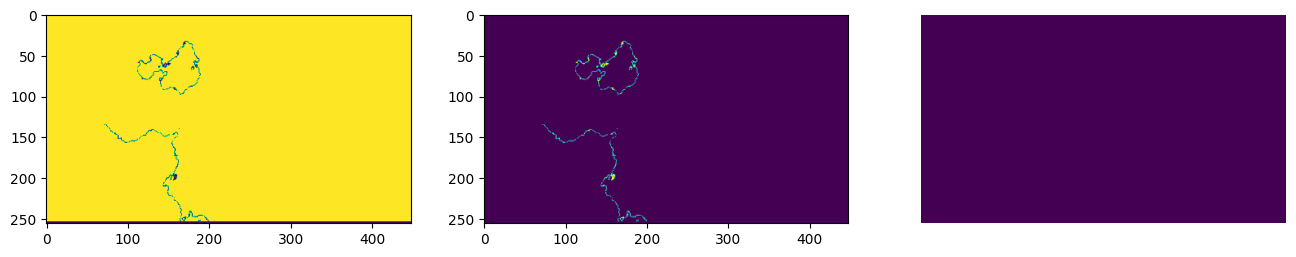

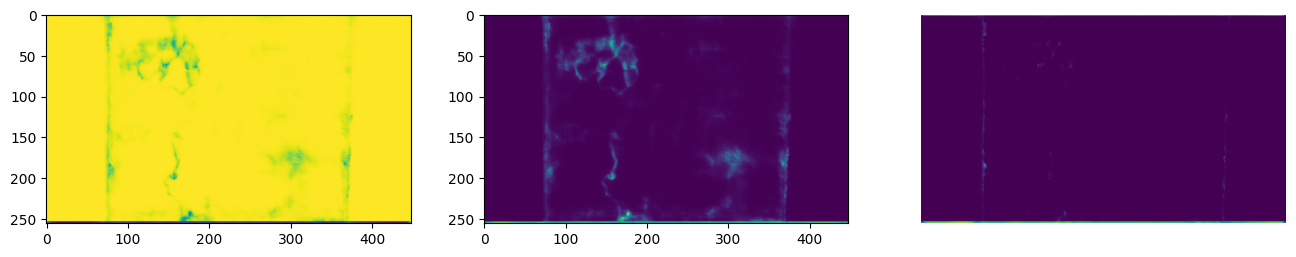

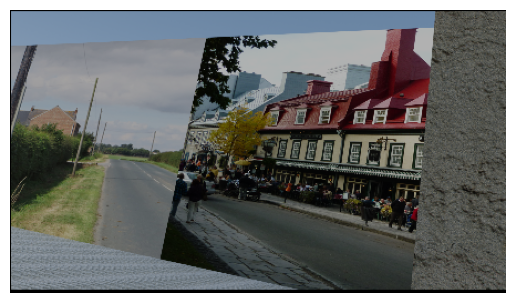

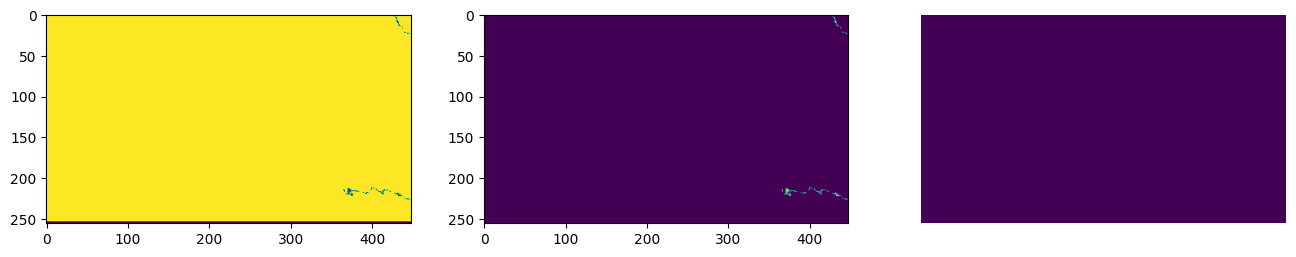

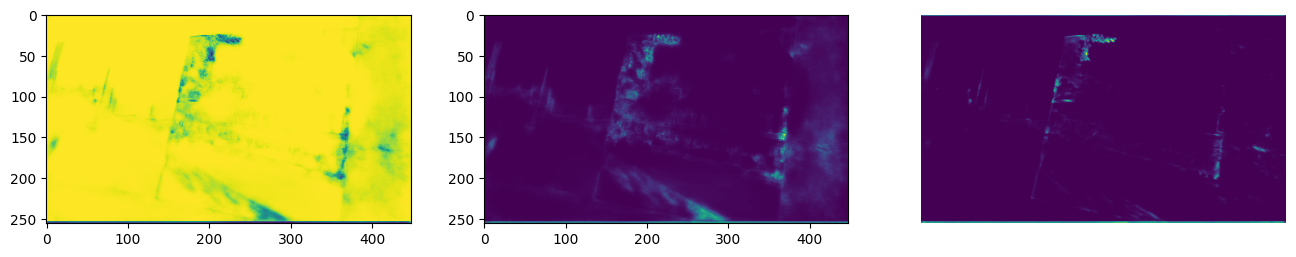

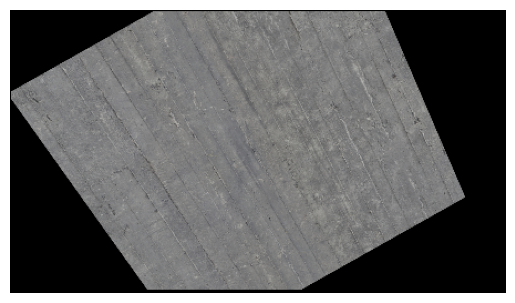

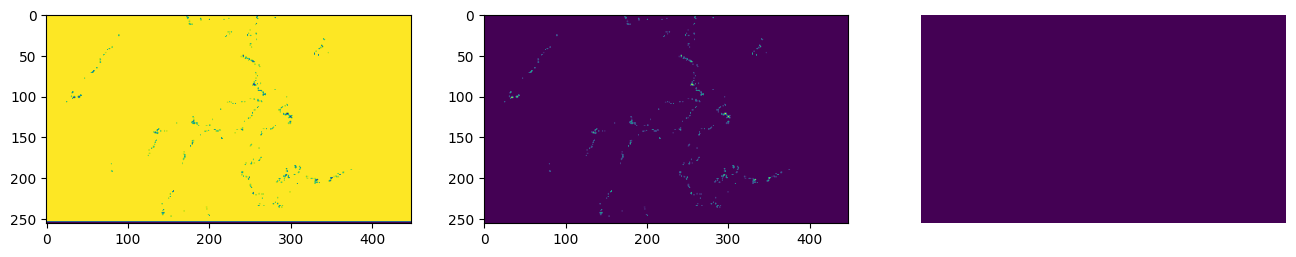

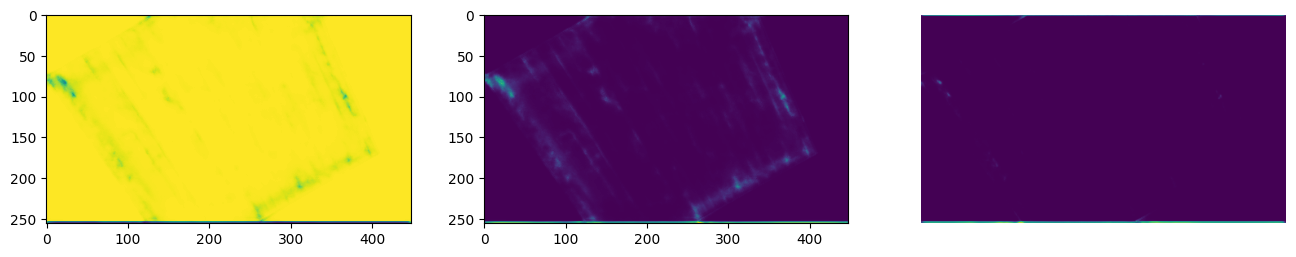

In [52]:
z = 1
for batch in val_dataset:
        x,y = batch
        z+=1
        show_img(x[0])
        show_label(y[0])
        pred = model.predict(x)
        show_pred(pred[0])
        if(z == 9):
          break